In [209]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [210]:
"""
PREPROCESSING HELPER FUNCTION

formats image files and converts into numpy arrays of the same shape, then saves to specified location

Returns 0 upon success, otherwise returns 1 (unsuccessful may be due to undesirable properties such as
large aspect ratio)
"""

def process_file(file_path, processed_file_path, target_size = 32, aspect_ratio_thres = 1.3):
    with Image.open(file_path) as image:
        # crop out the longer dimension so it's square
        width, height = image.size
        new_size = min(width, height)
        if new_size * aspect_ratio_thres < max(width, height):
            # print(f'skipped due to aspect ratio too high')
            return 1
        left = (width - new_size) / 2
        top = (height - new_size) / 2
        right = (width + new_size) / 2
        bottom = (height + new_size) / 2
        image = image.crop((left, top, right, bottom))
        
        # resize
        image = image.resize((target_size, target_size))

        # convert the image to RGB
        image = image.convert('RGB')
        
        # convert to numpy array
        img_array = np.array(image)

        # print(f'processed array shape: {img_array.shape}')
        if img_array.shape != (target_size, target_size, 3):
            print(f'error! wrong shape {img_array.shape}')
        
        # save to file
        np.save(processed_file_path, img_array)
        return 0

In [211]:
def feature_variation1(data):
    variance = np.var(data, axis=0)
    return np.sum(variance)

def feature_variation2(data):
    variance = np.var(data, axis=1)
    return np.sum(variance)

def feature_luminosity_variation1(data):
    lum = np.mean(data, axis=0)
    variance = np.var(lum, axis=0)
    return np.sum(variance)

def feature_luminosity_variation2(data):
    lum = np.mean(data, axis=1)
    variance = np.var(lum, axis=0)
    return np.sum(variance)

def feature_luminosity_variation3(data):
    lum = np.mean(data, axis=2)
    variance = np.var(lum, axis=0)
    return np.sum(variance)


def get_conv_function(filter):
    return lambda row : np.convolve(row, filter, 'same')

def thresholding(data):

    randint = int(np.random.random() * 100)

    if randint == 0:
        plt.imshow(data, interpolation='nearest')
        plt.show()

    filter = [-1,-0.2,0,0.2,1]
    result = np.apply_along_axis(get_conv_function(filter), 0, data)
    threshold = 30
    result = np.where(result < threshold, 0, 255)

    if randint == 0:
        plt.imshow(result, interpolation='nearest')
        plt.show()
        time.sleep(1)

    return np.sum(result)

"""
FEATURE EXTRACTION HELPER FUNCTION

One of the feature extraction methods

Extracts exactly 5 features for every data point and returns them as 1D numpy array
"""

def extract_5_features(data):
    features = np.ones((5,))
    features[0] = thresholding(data)
    features[1] = feature_variation2(data)
    features[2] = feature_luminosity_variation1(data)
    features[3] = feature_luminosity_variation2(data)
    features[4] = feature_luminosity_variation3(data)
    return features


def extract_3_features(data):
    features = np.ones((3,))
    features[1] = feature_variation2(data)
    #features[1] = feature_luminosity_variation1(data)
    features[2] = feature_luminosity_variation3(data)
    return features


In [212]:
"""
MAIN PIPELINE 1

preprocesses data by reading from directory and saves processed data into another directory with same structure.
"""

def preprocess(raw_data_dir, processed_data_dir):
    # Create the processed_data directory if it doesn't exist
    if not os.path.exists(processed_data_dir):
        os.makedirs(processed_data_dir)

    # List all subfolders in raw_data
    for subdir in os.listdir(raw_data_dir):
        print(f'reading directory {subdir}')
        raw_subdir_path = os.path.join(raw_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(raw_subdir_path):
            continue
        processed_subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Create the subfolder in processed_data if it doesn't exist
        if not os.path.exists(processed_subdir_path):
            os.makedirs(processed_subdir_path)
        
        count = 0
        processed_count = 0
        total = len(os.listdir(raw_subdir_path))
        # Process each file in the subdirectory
        for filename in os.listdir(raw_subdir_path):
            file_path = os.path.join(raw_subdir_path, filename)
            processed_file_path = os.path.join(processed_subdir_path, filename)
            
            # Process the file
            return_code = process_file(file_path, processed_file_path)
            count += 1
            if return_code == 0:
                processed_count += 1
            if count % 100 == 0 or count == total:
                print(f'traversed {count} / {total}, processed {processed_count}')
                
    print('finished preprocessing')

In [213]:
"""
MAIN PIPELINE 2

extracts features from processed data and returns them as two numpy arrays, X and Y
where X are the features for each data point and Y is their labels
"""

def import_features(processed_data_dir, features, features_extraction_function, folders=None, binary=False):
    total_items = 0
    # List all subfolders
    for subdir in os.listdir(processed_data_dir):
        if folders is not None and subdir not in folders:
            continue
        subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(subdir_path):
            continue
        total_items += len(os.listdir(subdir_path))
    print(f'found {total_items} items!')
        

    X = np.zeros((total_items, features))
    Y = np.zeros((total_items, 1))
    
    category_counter = 0
    item_counter = 0

    if binary: category_counter = -1

    # List all subfolders
    for subdir in os.listdir(processed_data_dir):
        if folders is not None and subdir not in folders:
            continue
        print(f'reading directory {subdir}')
        subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(subdir_path):
            continue
        
        # Process each file in the subdirectory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            data = np.load(file_path)
            features = features_extraction_function(data)
            
            X[item_counter] = features
            Y[item_counter][0] = category_counter
            item_counter += 1

            if item_counter % 100 == 0:
                print(f'processed {item_counter}/{len(os.listdir(subdir_path))}')

        category_counter += 1
        if binary: category_counter += 1

    print(f'label statistics: class -1 {np.sum(Y == -1)}, class 1 {np.sum(Y == 1)}')

    '''
    num_test = int(item_counter/8)
    test_indices = np.random.choice(item_counter, num_test, replace=False)
    Xtest = X[test_indices, :]
    Ytest = Y[test_indices, :]

    X = np.delete(X, test_indices, axis=0)
    Y = np.delete(Y, test_indices, axis=0)
    '''
    print('finished feature import')
    return X, Y

In [214]:
"""
RUNNER
"""

# directory containing original images
raw_data_dir = '../../Data/pokemon/PokemonData'

# directory to save processed numpy arrays
processed_data_dir = '../../Data/pokemon/PokemonDataProcessed'

# specifies which categories to read from. Leave as None to read from all
folders = ['Pikachu','Ditto']

# !!!!!!!!!!!!!!!!!!! UNCOMMENT BELOW TO ENABLE PREPROCESSING
#preprocess(raw_data_dir, processed_data_dir)

# category map represents the mapping for storing categories as an integer rather than having to use their original string
X, Y = import_features(processed_data_dir, 3, extract_3_features, folders, True)
print(f'X shape: {X.shape}\nY Shape: {Y.shape}')
Y = Y.reshape((len(Y),))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

found 159 items!
reading directory Ditto
reading directory Pikachu
processed 100/103
label statistics: class -1 56, class 1 103
finished feature import
X shape: (159, 3)
Y Shape: (159, 1)


TRAINING AND TESTING:

The code below uses default settings. The decision tree classifier is not constrained to any specific number of branching, leaf nodes or depth.

accuracy: 0.875


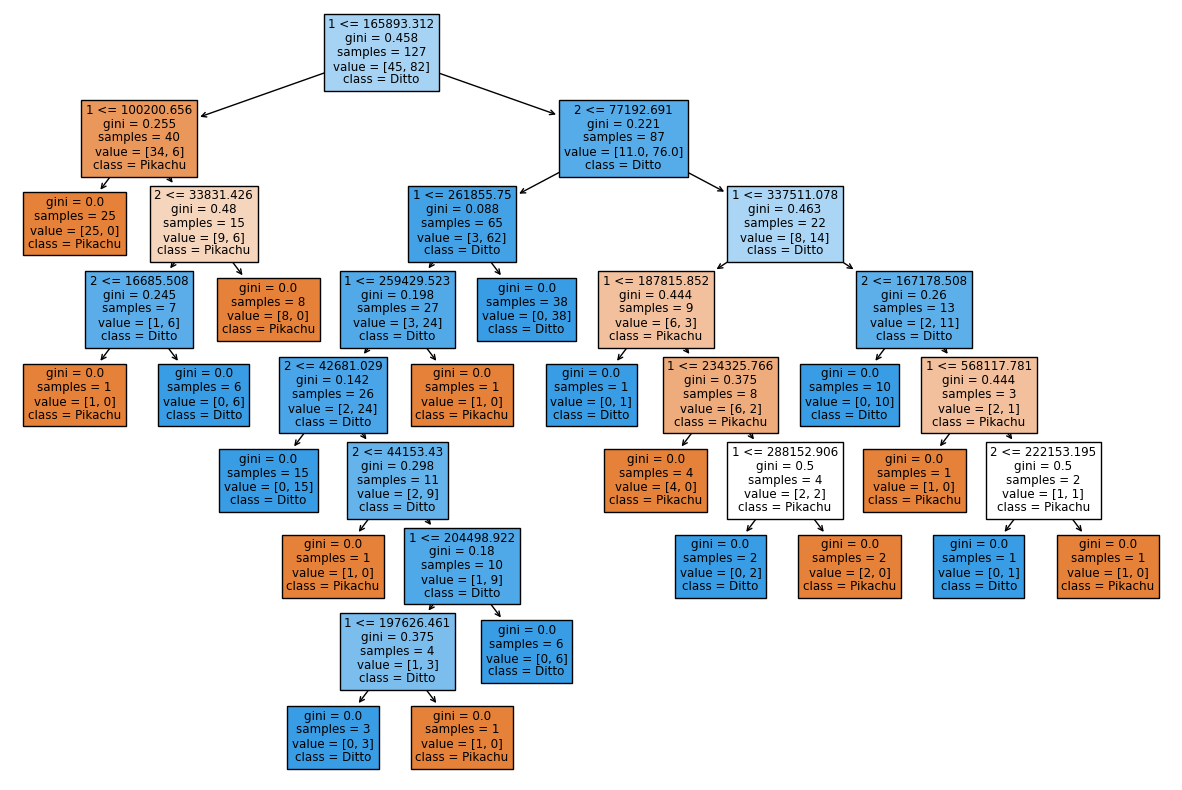

In [215]:
classifier = DecisionTreeClassifier(random_state=69)
classifier.fit(x_train, y_train)

predictions = classifier.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

print(f'accuracy: {accuracy}')

plt.figure(figsize=(15,10))
plot_tree(classifier, filled=True, feature_names=['0', '1', '2'], class_names=folders)
plt.show()

The classifier below is constrained to a maximum of 5 leaf nodes. This helps prevent overfitting, especially given the limited dataset (159) I have. I saw a small decrease in accuracy with this method.

accuracy: 0.84375


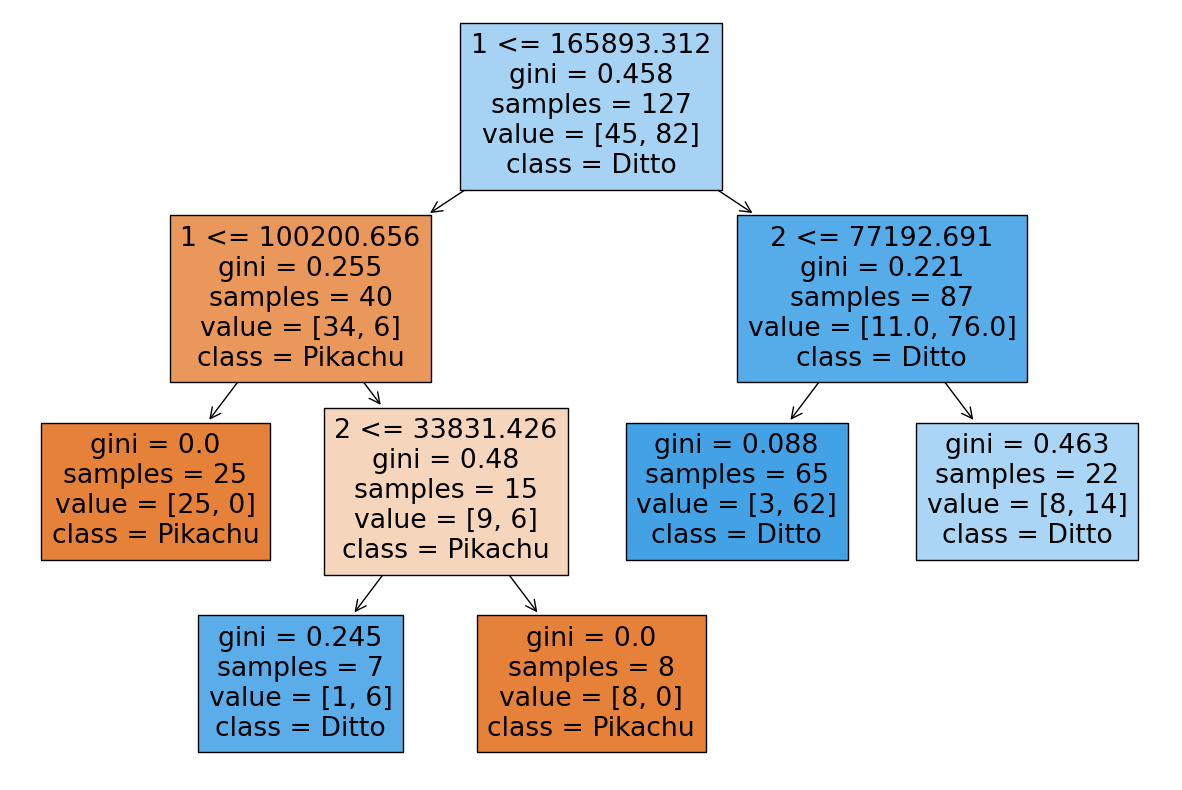

In [216]:
classifier = DecisionTreeClassifier(
    max_leaf_nodes=5,
    random_state=69
)
classifier.fit(x_train, y_train)

predictions = classifier.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

print(f'accuracy: {accuracy}')

plt.figure(figsize=(15,10))
plot_tree(classifier, filled=True, feature_names=['0', '1', '2'], class_names=folders)
plt.show()

I tried again, but this time it is constrained to a max depth of 3 and a min sample split of 2. This method cause my accuracy to increase from 0.875 to 0.906, a notable improvement in accuracy.

accuracy: 0.90625


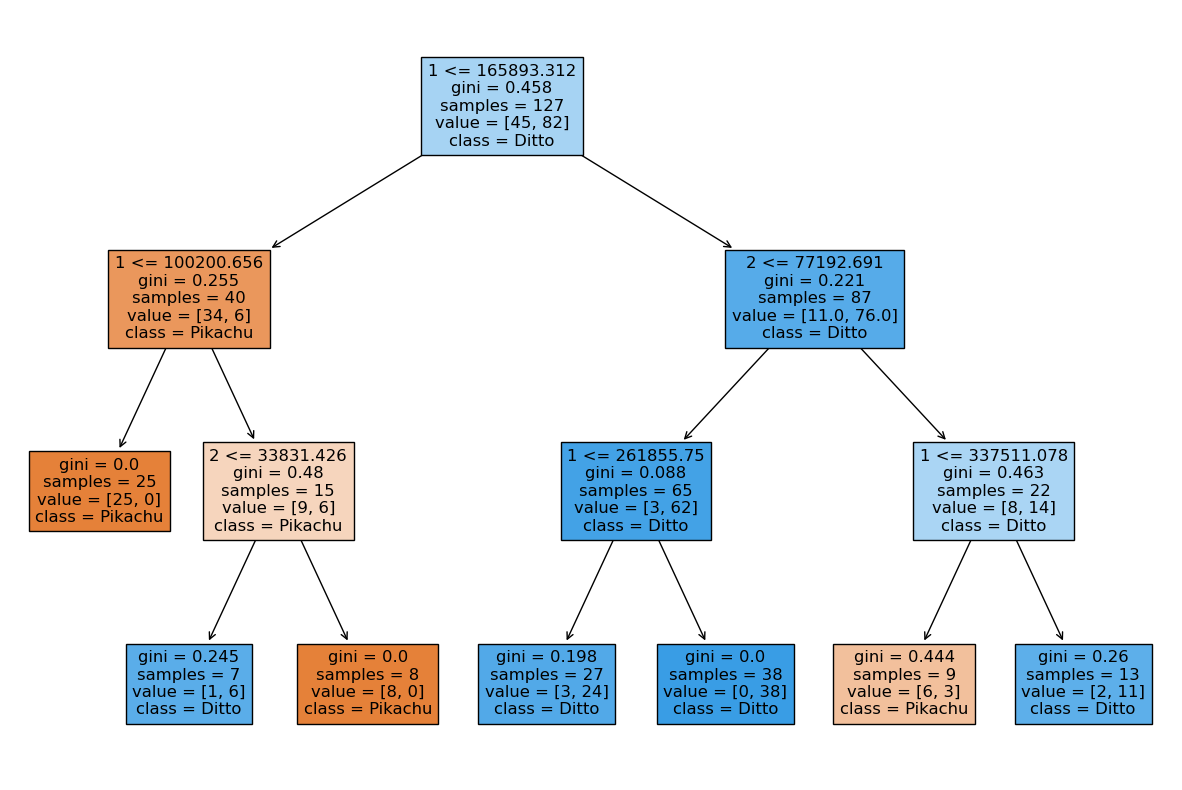

In [217]:
classifier = DecisionTreeClassifier(
    max_depth=3, 
    min_samples_split=2,
    random_state=69
)
classifier.fit(x_train, y_train)

predictions = classifier.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

print(f'accuracy: {accuracy}')

plt.figure(figsize=(15,10))
plot_tree(classifier, filled=True, feature_names=['0', '1', '2'], class_names=folders)
plt.show()

I relaxed the contraints from the previous attempt a little, with a max depth of 4 and min samples split of 3, and saw no difference in accuracy.

accuracy: 0.875


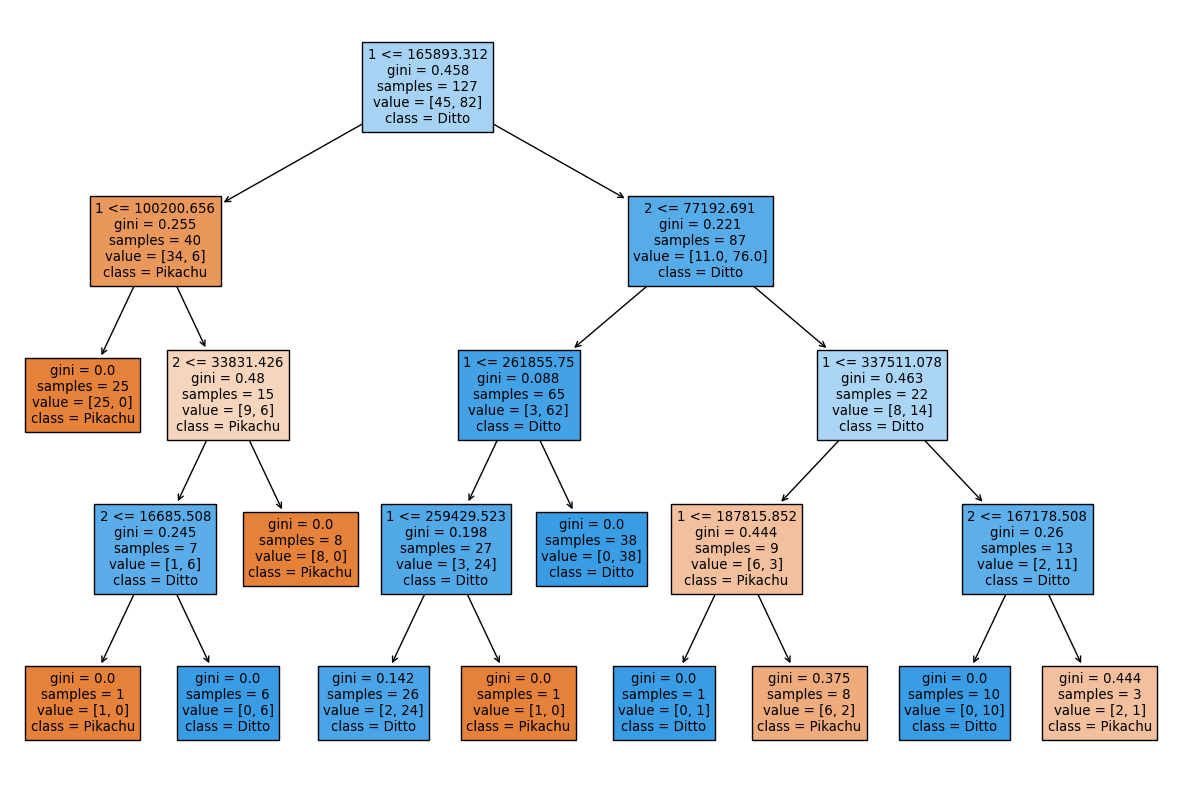

In [218]:
classifier = DecisionTreeClassifier(
    max_depth=4, 
    min_samples_split=3,
    random_state=69
)
classifier.fit(x_train, y_train)

predictions = classifier.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

print(f'accuracy: {accuracy}')

plt.figure(figsize=(15,10))
plot_tree(classifier, filled=True, feature_names=['0', '1', '2'], class_names=folders)
plt.show()

accuracy with bagging: 0.84375
k-fold mean accuracy: 0.8666666666666666


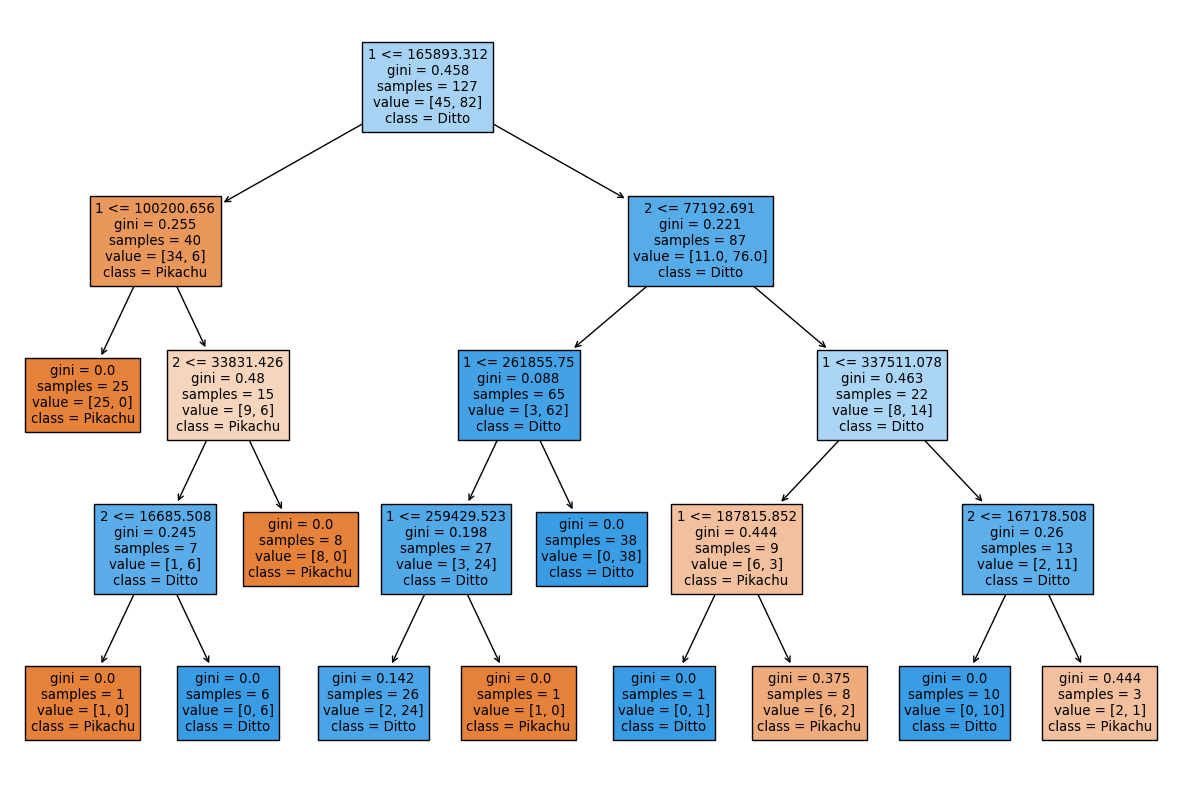

In [219]:
folds = 10

classifier_bagging = BaggingClassifier(
    estimator=classifier,
    n_estimators=10,
    random_state=69
)
classifier_bagging.fit(x_train, y_train)
predictions = classifier_bagging.predict(x_test)

cross_val_scores = cross_val_score(classifier_bagging, x_train, y_train, cv=folds)
accuracy = accuracy_score(y_test, predictions)

print(f'accuracy with bagging: {accuracy}')
print("k-fold mean accuracy:", cross_val_scores.mean())

plt.figure(figsize=(15,10))
plot_tree(classifier, filled=True, feature_names=['0', '1', '2'], class_names=folders)
plt.show()

c:\Users\eggyr\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\eggyr\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\eggyr\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\eggyr\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorit

accuracy with boosting: 0.84375
k-fold mean accuracy: 0.8826923076923077


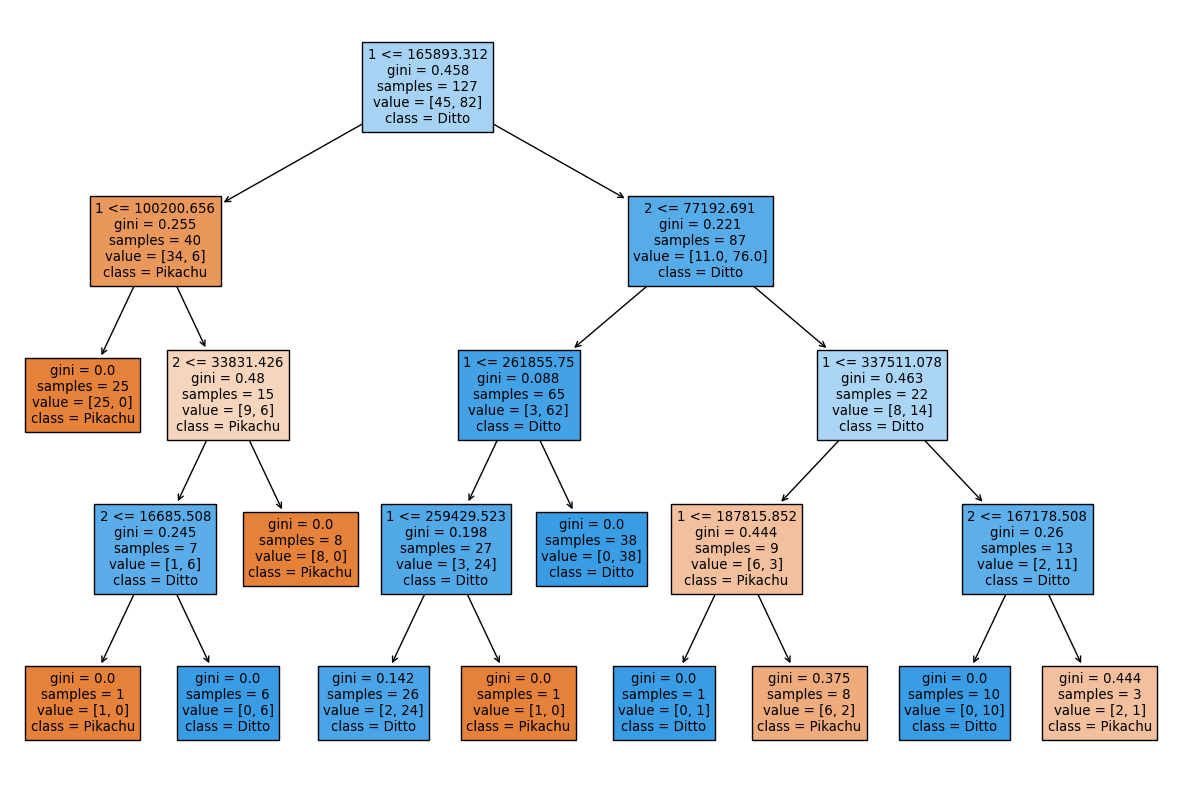

In [220]:
classifier_boosting = AdaBoostClassifier(
    estimator=classifier,
    n_estimators=10,
    random_state=69
)

classifier_boosting.fit(x_train, y_train)
predictions = classifier_boosting.predict(x_test)

cross_val_scores = cross_val_score(classifier_boosting, x_train, y_train, cv=folds)
accuracy = accuracy_score(y_test, predictions)

print(f'accuracy with boosting: {accuracy}')
print("k-fold mean accuracy:", cross_val_scores.mean())

plt.figure(figsize=(15,10))
plot_tree(classifier, filled=True, feature_names=['0', '1', '2'], class_names=folders)
plt.show()

The metric used in all of these was the classification accuracy of the pokemon images. Since I have two classes, I am determining if the decision tree correctly classified or not. Random choice should result in an accuracy of 0.5, and since the ratio of the two classes is 2:1, a naive solution of picking only the more frequent class should result in an accuracy of 0.66. Since all my accuracy exceeds 0.84, with the best accuracy being 0.906, I have demonstrated that the decision tree, as well as my feature selection, was able to perform satisfactorily. 

Using various contraining of the decision tree as well as bagging and boosting may not have had major impacts for these trials, but they are important for limiting overfitting in general. While bagging reduces overfitting, boosting reduces underfitting. In my case, I believe that methods of limiting overfitting, such as constraining the nodes of the decision tree and using bagging is more important due to my limited dataset. My best accuracy obtained, 0.906 from contraining the tree to a much smaller depth of 3 supports this claim.
